# Finding Donors
  - Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.

In [163]:
# Data preprocessing
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (29, 10)
# plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

# Distribution plots
from scipy import stats
from scipy.stats import norm

# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Encoding 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from time import time

In [164]:
data = pd.read_csv('census.csv')
data.head()

age          workclass education_level  education-num       marital-status  \
0   39          State-gov       Bachelors           13.0        Never-married   
1   50   Self-emp-not-inc       Bachelors           13.0   Married-civ-spouse   
2   38            Private         HS-grad            9.0             Divorced   
3   53            Private            11th            7.0   Married-civ-spouse   
4   28            Private       Bachelors           13.0   Married-civ-spouse   

           occupation    relationship    race      sex  capital-gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   capital-loss  hours-per-week  native-country income  
0           0.0            40.0   United-States  <=50K  
1           0.0            13.0   United-States  <=50K  
2           0.0            40.0   United-States  <=50K  
3           0.0            40.0   United-States  <=50K  
4           0.0            40.0            Cuba  <=50K

A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [165]:
n_records = len(data)
n_greater_50k = len(data[data['income'] == '>50K'])
n_at_most_50k = len(data[data['income'] == '<=50K'])
greater_percent = (n_greater_50k / n_records) * 100
print('The total number of records is {}'.format(n_records))
print('The total number of individuals making more than $50,000 annually is {}'.format(n_greater_50k))
print('The total number of individuals making at most $50,000 annually is {}'.format(n_at_most_50k))
print('The percentage of individuals making more than $50,000 annually is {:.2f} %'.format(greater_percent))

The total number of records is 45222
The total number of individuals making more than $50,000 annually is 11208
The total number of individuals making at most $50,000 annually is 34014
The percentage of individuals making more than $50,000 annually is 24.78 %


**Data Preprocessing**
- Transform skewed continuous variables
    - A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`age'`, '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these three features. Note the range of the values present and how they are distributed.

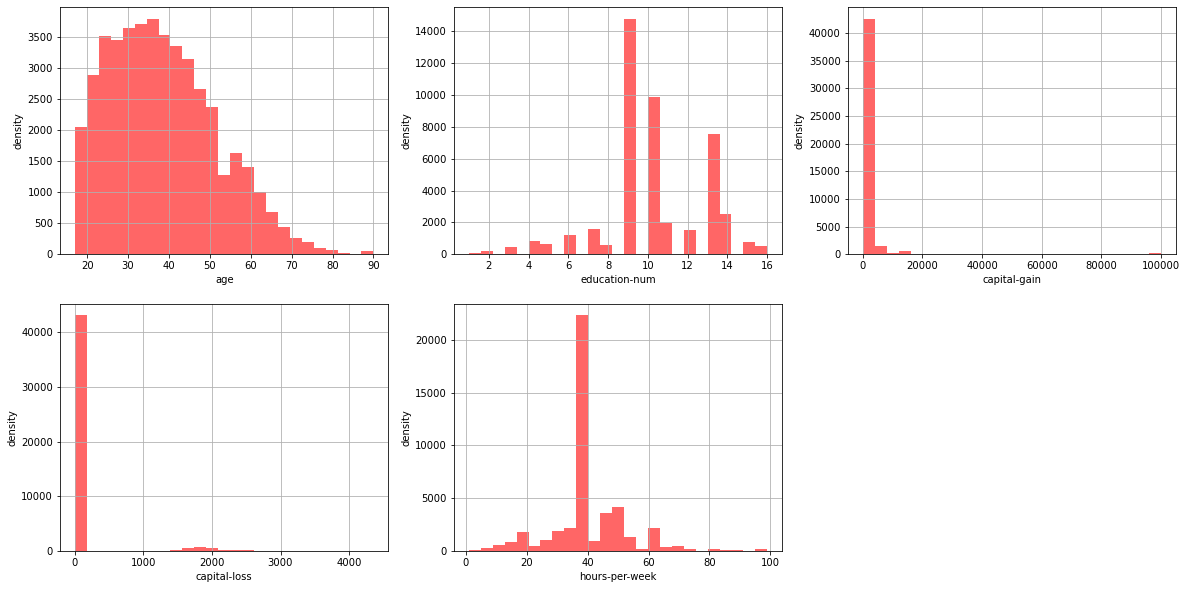

In [172]:
fig = plt.figure(figsize=(20, 10))
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for i, col in enumerate(numerical, start=1):
    fig.add_subplot(2, 3, i)
    data[col].hist(bins=25, color='r', alpha=0.6)
    plt.xlabel(col)
    plt.ylabel('density')
    plt.show

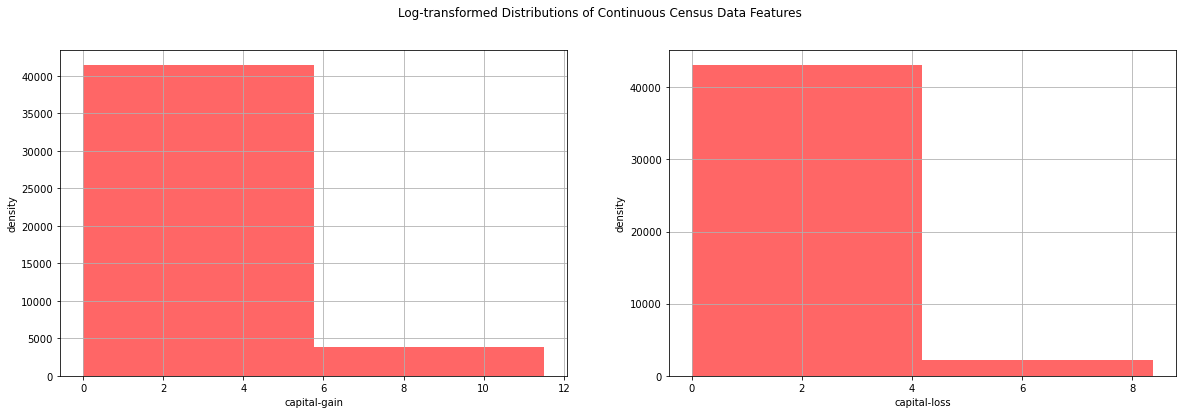

In [173]:
# Normalize the skewed data
skewed = ['capital-gain', 'capital-loss']
for col in skewed:
    data[col] = np.log(data[col].values + 1)


# View new results
fig = plt.figure(figsize=(20, 6))
for i, col in enumerate(skewed, start=1):
    fig.add_subplot(1, 2, i)
    data[col].hist(bins=2, color='r', alpha=0.6)
    plt.xlabel(col)
    plt.ylabel('density')
    plt.suptitle('Log-transformed Distributions of Continuous Census Data Features')
    plt.show

**Select independent and dependent variables**

In [67]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [69]:
X

age          workclass education_level  education-num  \
0       39          State-gov       Bachelors           13.0   
1       50   Self-emp-not-inc       Bachelors           13.0   
2       38            Private         HS-grad            9.0   
3       53            Private            11th            7.0   
4       28            Private       Bachelors           13.0   
...    ...                ...             ...            ...   
45217   33            Private       Bachelors           13.0   
45218   39            Private       Bachelors           13.0   
45219   38            Private       Bachelors           13.0   
45220   44            Private       Bachelors           13.0   
45221   35       Self-emp-inc       Bachelors           13.0   

            marital-status          occupation    relationship  \
0            Never-married        Adm-clerical   Not-in-family   
1       Married-civ-spouse     Exec-managerial         Husband   
2                 Divorced   Handlers-cleaners   Not-in-family   
3       Married-civ-spouse   Handlers-cleaners         Husband   
4       Married-civ-spouse      Prof-specialty            Wife   
...                    ...                 ...             ...   
45217        Never-married      Prof-specialty       Own-child   
45218             Divorced      Prof-specialty   Not-in-family   
45219   Married-civ-spouse      Prof-specialty         Husband   
45220             Divorced        Adm-clerical       Own-child   
45221   Married-civ-spouse     Exec-managerial         Husband   

                      race      sex  capital-gain  capital-loss  \
0                    White     Male        2174.0           0.0   
1                    White     Male           0.0           0.0   
2                    White     Male           0.0           0.0   
3                    Black     Male           0.0           0.0   
4                    Black   Female           0.0           0.0   
...                    ...      ...           ...           ...   
45217                White     Male           0.0           0.0   
45218                White   Female           0.0           0.0   
45219                White     Male           0.0           0.0   
45220   Asian-Pac-Islander     Male        5455.0           0.0   
45221                White     Male           0.0           0.0   

       hours-per-week  native-country  
0                40.0   United-States  
1                13.0   United-States  
2                40.0   United-States  
3                40.0   United-States  
4                40.0            Cuba  
...               ...             ...  
45217            40.0   United-States  
45218            36.0   United-States  
45219            50.0   United-States  
45220            40.0   United-States  
45221            60.0   United-States  

[45222 rows x 13 columns]

**Encode Categorical Variables**

In [70]:
ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(), [1, 2, 4, 5, 6, 7, 8, 12])
], remainder='passthrough')
X = ct.fit_transform(X).toarray() 

In [71]:
mapper = {
    '<=50K': 0,
    '>50K': 1
}
y = y.apply(lambda x: mapper[x]).values

In [72]:
print('The total features before one-hot encoding was {} columns. The total features after one-hot encoding is now {}.'.format(data.shape[1] - 1, X.shape[1]))

The total features before one-hot encoding was 13 columns. The total features after one-hot encoding is now 103.


**Split data into training set and test set**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("The training set has {} samples.".format(X_train.shape[0]))
print("The testing st has {} samples.".format(X_test.shape[0]))

The training set has 36177 samples.
The testing st has 9045 samples.


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In [74]:
TP = np.sum(y)
FP = len(y) - TP
TN = 0
FN = 0

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = 2 * (precision * recall) / (precision + recall)

# f1 beta score
beta = 0.5
fscore = (1 + beta**2) * precision * recall / ((beta**2 * precision) + recall)
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3972, F-score: 0.2917]


**Supervised Learning Models**
- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- Pick three models for this model


1. ##### **Gaussian Naive Bayes (GaussianNB)**
    - **Real-world application**: This algorithm can be used in the media industry to classifiy articles or posts into different topics on a website; politics, sports, word news etc.
    - **Strengths**: Fast and accurate method of prediction. Can be used in multiple prediction problems. It performs well with **categorical input variables** compared to  numerical variables.
    - **Weaknesses**: Unable to make predictions if there is no training tuples in a patricular class.
    - **Good candidate?** It's a good candidate for this problem.
2. ##### **Decision Trees**
   - **Real-world application**: This algorithm can be used in real estate agencies to determine the optimal selling price of a house based on its features.
   - **Strengths**: Easy to implement. Used to solve both classification and regression problems.
   - **Weaknesses**: Inconsistent predictions based on overfitting and very large datasets.
   - **Good candidate?** It's a good candidate for this problem.
3. ##### **Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting*)**
   - **Real-world application**: Can be used in criminal investigations; facial recognition software to identify suspects.
   - **Strengths**: They improve average prediction performace of the contributing members in the ensemble.
   - **Weaknesses**: Difficult to interpret.
   - **Good candidate?** It's a good candidate for this problem.
4. ##### **K-Nearest Neighbors (KNeighbors)**
   - **Real-world application**: Used in retail to detect anomalies in credit card usage.
   - **Strengths**: Quick calculation time. Easy to interpret. High accuracy.
   - **Weaknesses**: Although it is a fast algorithm, as data grows the speed declines significanlty.
   - **Good candidate?** It's a good candidate for this problem.
5. ##### **Stochastic Gradient Descent Classifier (SGDC)**
   - **Real-world application**: Evaluation of performace of an employee in an organization.
   - **Strengths**: Useful when number of variables is large.
   - **Weaknesses**: Not suitable for large datasets.
   - **Good candidate?** It's not ideal for this problem because it will underperform with large dataset.
6. ##### **Support Vector Machines (SVM)***
   - **Real-world application**: Used to recognize hand-written characters and validating signatures on documents.
   - **Strengths**: Works well with structure and unstructured data.
   - **Weaknesses**: May lead to overfitting if more variables are added.
   - **Good candidate?** It's a good candidate for this problem because it is used for binary classification as we have in the dataset target variable.
7. #### **Logistic Regression***
   - **Real-world application**: Credit card company wants to know wheter a transaction is fraudulent or not.
   - **Strengths**: Does not require tuning; feature scaling. Easy to implement.
   - **Weaknesses**: May lead to overfitting if more variables are added.
   - **Good candidate?** It's a good candidate for this problem because it is used for binary classification as we have in the dataset target variable.
   
   
##### **Picked Models**
1. **Gradient Boosting**
2. **Stochastic Gradient Classifier**
3. **Logistic Regression**

**Create a Training and Testing Pipeline**

In [75]:
from sklearn.metrics import fbeta_score, accuracy_score


def train_predict(classifier, X_train, y_train, X_test, y_test):
    results = {}
    
    # Training     
    start = time()
    classifier = classifier.fit(X_train, y_train)
    end = time()
    
    results['train_time'] = end - start
    
    
    # Testing
    start = time()
    predicted_test = classifier.predict(X_test)
    end = time()
    
    results['test_time'] = end - start
    
    # Accuracy Score
    score = accuracy_score(y_test, predicted_test)
    results['accuracy_score'] = score
    
    # F1_Score (BETA = 0.5)
    f1_score = fbeta_score(y_test, predicted_test, beta=0.5)
    results['f1_score(0.5)'] = f1_score
    
    
    print('{} is ready to show results \U0001F600'.format(classifier.__class__.__name__))
    return results

In [29]:
clf_A = LogisticRegression()
clf_B = GradientBoostingClassifier()
clf_C = SGDClassifier()

results = {}
for i, clf in enumerate([clf_A, clf_B, clf_C]):
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name][i] = train_predict(clf, X_train, y_train, X_test, y_test)

C:\Users\oneda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression is ready to show results 😀
GradientBoostingClassifier is ready to show results 😀
SGDClassifier is ready to show results 😀


In [30]:
results

{'LogisticRegression': {0: {'train_time': 1.6480495929718018,
   'test_time': 0.008001327514648438,
   'accuracy_score': 0.8423438363736871,
   'f1_score(0.5)': 0.7018716577540107}},
 'GradientBoostingClassifier': {1: {'train_time': 32.73813819885254,
   'test_time': 0.032012224197387695,
   'accuracy_score': 0.8637921503593146,
   'f1_score(0.5)': 0.7579844626672421}},
 'SGDClassifier': {2: {'train_time': 1.3973140716552734,
   'test_time': 0.002155780792236328,
   'accuracy_score': 0.808955223880597,
   'f1_score(0.5)': 0.6241765480895916}}}

**Improving Results**

In [31]:
clf = GradientBoostingClassifier()

parameters = {'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [100, 150, 200]}

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

# Unoptimized model predictions
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8638
F-score on testing data: 0.7580

Optimized Model
------
Final accuracy score on the testing data: 0.8708
Final F-score on the testing data: 0.7671


In [76]:
best_clf

GradientBoostingClassifier(learning_rate=0.2, n_estimators=150)

**Feature Importance**
- An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power.
- Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importances_` attribute, which is a function that ranks the importance of features according to the chosen classifier.

In [180]:
start = time()
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
end = time()
all_features_time = end - start

importances = model.feature_importances_

print('Training time\n------')
print('{}'.format(all_features_time))
print('Best features importances\n------')
print('{}'.format(importances))

Training time
------
24.196728944778442
Best features importances
------
[1.74291305e-03 3.73737581e-04 4.13094729e-05 9.45678047e-04
 4.31349591e-03 0.00000000e+00 1.56966164e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.30988332e-05 0.00000000e+00
 6.65339516e-05 8.31629540e-05 2.88367066e-03 1.47264434e-04
 1.12933742e-04 2.81486364e-04 5.66576821e-05 0.00000000e+00
 7.80368661e-04 3.96494216e-01 0.00000000e+00 4.32326017e-04
 0.00000000e+00 0.00000000e+00 3.02508370e-05 0.00000000e+00
 3.07721092e-05 1.69680852e-02 4.44065271e-03 6.61349229e-04
 6.95344028e-04 5.02241208e-03 0.00000000e+00 7.21013723e-03
 2.66802225e-04 5.27623284e-04 5.32066506e-04 3.19140213e-05
 1.63863607e-03 6.03767577e-05 3.86212239e-05 1.93961469e-04
 8.99261822e-05 4.98543855e-03 0.00000000e+00 3.67490205e-05
 0.00000000e+00 0.00000000e+00 2.86283939e-04 0.00000000e+00
 1.55222649e-03 9.87131025e-05 8.77259038e-05 0.00000000e+00
 0.00000000e

Text(0, 0.5, 'Index of Feature')

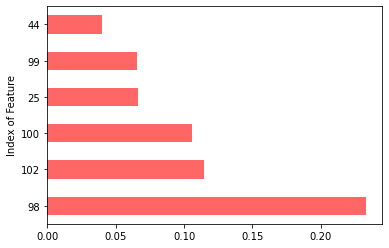

In [178]:
pd.Series(importances).nlargest(6).plot(kind='barh', color='r', alpha=0.6)
plt.ylabel('Index of Feature')

In [184]:
reduced_features = pd.Series(importances).nlargest(5).index

X_train_reduced = X_train[:, reduced_features]
X_test_reduced = X_test[:, reduced_features]

start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
reduced_features_time = end - start

reduced_predictions = clf.predict(X_test_reduced)

print("Final Model trained on full data: Optimized Model\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

print("\nModel training times between all features and reduced features\n------")
print("All features: {:.4f}".format(all_features_time))
print("Reduced features: {:.4f}".format(reduced_features_time))
print("Model training time difference: {:.4f}".format(all_features_time - reduced_features_time))

best_acc_minus_reduced = (accuracy_score(y_test, best_predictions) - accuracy_score(y_test, reduced_predictions)) * 100
best_f_score_minus_reduced = (fbeta_score(y_test, best_predictions, beta = 0.5) - fbeta_score(y_test, reduced_predictions, beta = 0.5)) * 100
time_difference = all_features_time - reduced_features_time
print("\nDifferences in F-score\n------")
print("The F-score reduced by: {:.2f} %".format(best_f_score_minus_reduced))
print("The accuracy reduced by: {:.2f} %".format(best_acc_minus_reduced))
print(f"\nThe difference in training time is {time_difference} seconds. \
If training time wasn't an important factor in this problem as well as the reduced F-score, then using the five reduced features would be considered.")

Final Model trained on full data: Optimized Model
------
Accuracy on testing data: 0.8708
F-score on testing data: 0.7671

Final Model trained on reduced data
------
Accuracy on testing data: 0.8606
F-score on testing data: 0.7468

Model training times between all features and reduced features
------
All features: 24.1967
Reduced features: 2.1160
Model training time difference: 22.0807

Differences in F-score
------
The F-score reduced by: 2.02 %
The accuracy reduced by: 1.02 %

The difference in training time is 22.080710411071777 seconds. If training time wasn't an important factor in this problem as well as the reduced F-score, then using the five reduced features would be considered. 
